In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.model_selection import train_test_split

In [3]:
data=[]
base_path='C:\\Users\luann\Documents\AIS\Intelliguard\IntelliGuard\PHEME\PHEME_veracity\\all-rnr-annotated-threads'

In [4]:
import os
import json
import pandas as pd

def load_pheme_dataset(base_path):
    data = []
    
    for event in os.listdir(base_path):
        event_path = os.path.join(base_path, event)
        if not os.path.isdir(event_path):
            # print('no such directory')
            continue

        for category in ['rumours', 'non-rumours']:
            category_path = os.path.join(event_path, category)
            if not os.path.exists(category_path):
                #print('no such category directory')
                continue

            for thread_id in os.listdir(category_path):
                # Skip non-numeric directories
                if not thread_id.isdigit():
                    #print('no such thread')
                    continue
                
                thread_path = os.path.join(category_path, thread_id)
                source_tweet_path = os.path.join(
                    thread_path, 
                    'source-tweets', 
                    f'{thread_id}.json'
                )

                # Verify critical paths
                if not os.path.exists(source_tweet_path):
                    # print('no such source tweet')
                    continue

                try:
                    with open(source_tweet_path, 'r', encoding='utf-8') as f:
                        #print('found available data file')
                        tweet = json.load(f)
                except Exception as e:
                    print(f"Error loading {thread_id}: {str(e)}")
                    continue

                data.append({
                    'thread_id': thread_id,
                    'text': tweet.get('text', ''),
                    'event': event,
                    'category': category
                })
    
    return pd.DataFrame(data)

# Usage
df = load_pheme_dataset(base_path)

if not df.empty:
    print(f"Success! Loaded {len(df)} threads")
    print(df.head())
else:
    print("""
    No data loaded. Check:
    1. Dataset path is correct
    2. Directory structure matches PHEME requirements
    3. Thread folders contain source-tweet JSONs
    """)

Success! Loaded 6425 threads
            thread_id                                               text  \
0  552783238415265792  Breaking: At least 10 dead, 5 injured after tO...   
1  552783667052167168  France: 10 people dead after shooting at HQ of...   
2  552783745565347840  Ten killed in shooting at headquarters of Fren...   
3  552784168849907712  BREAKING: 10 dead in shooting at headquarters ...   
4  552784526955806720  Reuters: 10 people shot dead at headquarters o...   

                          event category  
0  charliehebdo-all-rnr-threads  rumours  
1  charliehebdo-all-rnr-threads  rumours  
2  charliehebdo-all-rnr-threads  rumours  
3  charliehebdo-all-rnr-threads  rumours  
4  charliehebdo-all-rnr-threads  rumours  


In [5]:
import re
def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # Remove URLs/mentions/hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # Remove special characters
    text = text.lower().strip()                   # Lowercase and trim
    return text

df['cleaned_text']=df['text'].apply(clean_text)

In [6]:
df.head()

,thread_id,text,event,category,cleaned_text
0,552783238415265792,"Breaking: At least 10 dead, 5 injured after tO...",charliehebdo-all-rnr-threads,rumours,breaking at least dead injured after to gunm...
1,552783667052167168,France: 10 people dead after shooting at HQ of...,charliehebdo-all-rnr-threads,rumours,france people dead after shooting at hq of sa...
2,552783745565347840,Ten killed in shooting at headquarters of Fren...,charliehebdo-all-rnr-threads,rumours,ten killed in shooting at headquarters of fren...
3,552784168849907712,BREAKING: 10 dead in shooting at headquarters ...,charliehebdo-all-rnr-threads,rumours,breaking dead in shooting at headquarters of ...
4,552784526955806720,Reuters: 10 people shot dead at headquarters o...,charliehebdo-all-rnr-threads,rumours,reuters people shot dead at headquarters of f...


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
class PHEMEDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [9]:
# Prepare labels (assuming 'rumours' = 1, 'non-rumours' = 0)
df['label'] = df['category'].map({'rumours': 1, 'non-rumours': 0})

Class Distribution:
label
0    4023
1    2402
Name: count, dtype: int64


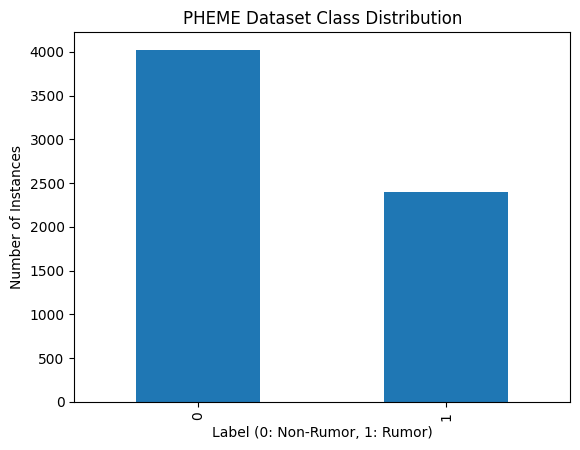

In [ ]:
# DataFrame 'df' with a column 'label' where 0 = non-rumor and 1 = rumor
print("Class Distribution:")
print(df['label'].value_counts())

# Plotting a bar chart for visual analysis
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("PHEME Dataset Class Distribution")
plt.xlabel("Label (0: Non-Rumor, 1: Rumor)")
plt.ylabel("Number of Instances")
plt.show()


In [11]:
BATCH_SIZE = 16
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

In [12]:
train_df,val_df=train_test_split(
    train_val_df,
    test_size=0.1,
    stratify=train_val_df['label'],
    random_state=42
)

In [13]:
# Create datasets
train_dataset = PHEMEDataset(
    texts=train_df['cleaned_text'],
    labels=train_df['label'],
    tokenizer=tokenizer
)

val_dataset = PHEMEDataset(
    texts=val_df['cleaned_text'],
    labels=val_df['label'],
    tokenizer=tokenizer
)

test_dataset = PHEMEDataset(
    texts=test_df['cleaned_text'],
    labels=test_df['label'],
    tokenizer=tokenizer
)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [15]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Binary classification (rumor vs non-rumor)
).to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
DEVICE='cuda'

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

In [18]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='binary')  # or 'macro' if multi-class

    print("Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, preds))
    print("Classification Report:")
    print(classification_report(true_labels, preds, digits=4))

    return acc, precision, recall, f1


In [19]:
import numpy as np
import torch

# Suppose train_dataset.labels is a pandas Series or list of labels
labels = np.array(train_dataset.labels)

# Get unique classes and their counts
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Compute weights as the inverse of counts (or use other heuristics)
weights = 1.0 / class_counts
print("Class weights:", weights)

# Convert weights to a torch tensor and move to device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(weights, dtype=torch.float).to(device)


Class weights: [0.0003453  0.00057803]


In [20]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [21]:
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    epoch_loss=0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for batch in train_loader:
        
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits=outputs.logits
        loss=loss_fn(logits,labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)

        train_preds.extend(predictions.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    epoch_loss = train_loss / len(train_loader)
    epoch_acc = accuracy_score(train_labels, train_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')


    print("Evaluation:")
    evaluate(model, val_loader, DEVICE)


Epoch [1/20]
Training Loss: 0.6613, Training Accuracy: 0.6001
Evaluation:
Evaluation Metrics:
Accuracy:  0.6848
Precision: 0.5510
Recall:    0.8438
F1 Score:  0.6667
Confusion Matrix:
[[190 132]
 [ 30 162]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8636    0.5901    0.7011       322
           1     0.5510    0.8438    0.6667       192

    accuracy                         0.6848       514
   macro avg     0.7073    0.7169    0.6839       514
weighted avg     0.7469    0.6848    0.6882       514

Epoch [2/20]
Training Loss: 0.5625, Training Accuracy: 0.7399
Evaluation:
Evaluation Metrics:
Accuracy:  0.7626
Precision: 0.6446
Recall:    0.8125
F1 Score:  0.7189
Confusion Matrix:
[[236  86]
 [ 36 156]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8676    0.7329    0.7946       322
           1     0.6446    0.8125    0.7189       192

    accuracy                         0.7626      

In [22]:
# Save entire model (architecture + weights)
torch.save(model.state_dict(), "bert_rumor_detection.pth")

In [23]:

# Load model with the same architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load("bert_rumor_detection.pth"))

# Move model to the appropriate device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        all_preds.append(logits)
        all_labels.append(labels)

# Convert predictions and labels to CPU for metric calculation
preds = torch.cat(all_preds)
labels = torch.cat(all_labels)

# Compute performance metrics
acc, precision, recall, f1 = evaluate(model,test_loader,DEVICE)

print(f"Test: Acc={acc:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")


Evaluation Metrics:
Accuracy:  0.8475
Precision: 0.7971
Recall:    0.7937
F1 Score:  0.7954
Confusion Matrix:
[[708  97]
 [ 99 381]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8773    0.8795    0.8784       805
           1     0.7971    0.7937    0.7954       480

    accuracy                         0.8475      1285
   macro avg     0.8372    0.8366    0.8369      1285
weighted avg     0.8473    0.8475    0.8474      1285

Test: Acc=0.8475, Prec=0.7971, Rec=0.7937, F1=0.7954
